In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse

## VAE on cosmology data

In [2]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              img_size=256,
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0][0:1]

# load model
model = load_model(model_name='resnet18', device=device, data_path=p.data_path)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

## autoencoder

In [3]:
class Mask_WaveCoeffs(nn.Module):
    def __init__(self, img_size=256, J=5, device='cuda'):
        super(Mask_WaveCoeffs, self).__init__()
        self.img_size = img_size
        self.num = J+1

        # initialize masks 
        x = torch.randn(1,1,img_size,img_size).to(device)
        xfm = DTCWTForward(J=J, biort='near_sym_b', qshift='qshift_b').to(device)
        Yl, Yh = xfm(x)   
        
        self.mask = nn.ParameterList([nn.Parameter(torch.ones_like(Yl))])
        for i in range(J):
            self.mask.append(nn.Parameter(torch.ones_like(Yh[i])))
            
        
    def forward(self, x):
        output_list = []
        for i in range(self.num):
            output_list.append(torch.mul(x[i], self.mask[i]))
        return tuple(output_list)
    
    
    def projection(self):
        for i in range(self.num):
            self.mask[i].data = torch.clamp(self.mask[i].data, 0, 1)

class InputXGradient(nn.Module):
    def __init__(self, mt, target=1, device='cuda'): 
        super(InputXGradient, self).__init__()
        self.mt = mt.to(device)
        self.target = target
        
        
    def forward(self, x):
        n = len(x)
        for i in range(n):
            x[i].retain_grad()
        output = self.mt(x)[0][self.target]
        output.backward(retain_graph=True)
        
        # input * gradient
        scores = []
        for i in range(n):
            scores.append(torch.mul(x[i], x[i].grad))
        return tuple(scores)  

In [4]:
# input
torch.manual_seed(p.seed)
im = iter(train_loader).next()[0][0:1].to(device)
im.requires_grad = True

# prepare model
autoenc = AutoEncoderSimple(img_size=p.img_size, hid_channels=2).to(device)

# train
p.lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=p.lr)

In [5]:
# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 100

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader, 0):
        data = data.to(device)
        recon_data, latent_sample = autoenc(data)
        # loss
        loss = _reconstruction_loss(data, recon_data, distribution="gaussian", storer=None)
        # zero grad
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update step
        optimizer.step()
        
        epoch_loss += loss.data.item()

        # Output training stats
        if batch_idx % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data.item()), end='')
        

    # Save Losses for plotting later
    losses.append(epoch_loss/(batch_idx + 1))

# SAVE MODEL
# torch.save(model.state_dict(), 'results/autoenc_6layer.pth')

Starting Training Loop...
Train Epoch: 99 [28800/30000 (96%)]	Loss: 861.622681

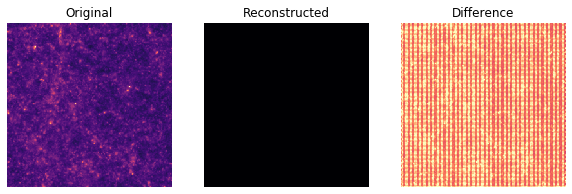

In [6]:
im = iter(train_loader).next()[0].to(device)
recon_data, latent_sample = autoenc(im)
viz_im_r(im[0,0], recon_data[0,0])

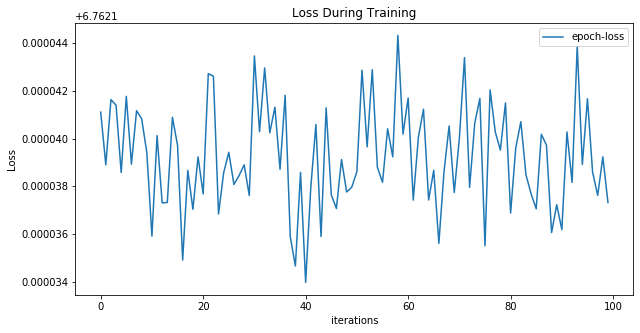

In [7]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(np.log(losses), label="epoch-loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
viz_filters(autoenc.conv1.weight[:,0,...], n_row=1, n_col=6, resize_fac=1, normalize=True, title='Conv Filters')

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 1080x1080 with 0 Axes>

In [ ]:
viz_filters(model.encoder(im)[0], n_row=1, n_col=2, normalize=True, resize_fac=1, title='Representation')